In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import *
import numpy as np
import random
import torchvision.transforms as transforms
import torch.nn as nn
from tqdm import tqdm
import timm
import albumentations as A
from sklearn.model_selection import KFold
import cv2
import os
from glob import glob
from albumentations.pytorch import ToTensorV2
import torch.optim as optim

In [2]:
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
random_seed = 1120
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [4]:
# transform = transforms.Compose([
#     transforms.Resize((224,224)),
#     transforms.GaussianBlur(7),
#     transforms.RandomHorizontalFlip(p=0.2),
#     transforms.RandomVerticalFlip(p=0.2),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,0.5,0.5),(0.224,0.224,0.224))
# ])


transform = A.Compose([
    A.Resize(224,224),
#     A.GaussNoise(p=0.1),
#     A.HorizontalFlip(p=0.2),
#     A.ColorJitter(),
    A.Normalize(),
    ToTensorV2(),
])
valt=A.Compose([
  A.Resize(224,224),
    A.Normalize(),
    ToTensorV2(),
])

# RandomResizeCrop
# Random GaussianNoise
# color jitter -> b/s/h/c  0.2 ~ 3  ||  128
# RandomHorzital

In [5]:
cnt=0
ctoi={k : idx for idx,k in enumerate(os.listdir('/media/data2/rjsdn/dacon/basic_image_classification/train'))}
itoc = {v: k for k, v in ctoi.items()}

In [6]:
ctoi

{'deer': 0,
 'frog': 1,
 'automobile': 2,
 'dog': 3,
 'truck': 4,
 'bird': 5,
 'cat': 6,
 'ship': 7,
 'horse': 8,
 'airplane': 9}

In [7]:
class Mydataset(Dataset):
    def __init__(self,path,transform=None):
        super(Mydataset).__init__()
        self.path=path
        self.transform=transform
        
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self,idx):
        img = self.path[idx]
        label = img.split('/')[-2]
        label = ctoi[label]
        
        img = cv2.imread(img)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        img = self.transform(image=img)['image']
            
        return img,label
        
        

In [8]:
def lite_save(state, epoch, save_dir, model):
    os.makedirs(save_dir, exist_ok=True)
    
    target_path = f'{save_dir}/{state}.path.tar'
    
    with open(target_path, "wb") as f:
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),}, f)

In [9]:

# learning rate scheduler -> StepLR || Cosine Annealing

# optimzier Adam || AdamW || AadmP || AdamB ? 

# Regularizer -> 써보고

In [10]:
def train(train_param):
    res = {
        'train_acc' :[],
        'train_loss':[],
        'val_loss':[],
        'val_acc': []
    }


    trainloader = train_param['trainloader']
    valloader = train_param['valloader']
    model = train_param['model']
    opt = train_param['opt']
    criterion = train_param['criterion']
    scheduler = train_param['scheduler']
    SAVE_PATH = train_param['SAVE_PATH']
    
    
    best_acc = 0
    for epoch in range(epochs):
        train_loss=0
        train_acc=0 
        train_size=0
        loader_size = len(trainloader)
        model.train()
        for data in tqdm(trainloader):
            x = data[0].to(device)
            y = data[1].to(device)
            train_size+=len(y)

            opt.zero_grad()
            output = model(x)
            loss = criterion(output,y)
            loss.backward()
            opt.step()

            _,output = output.max(1)
            train_acc += (output==y).sum().item()
            train_loss += loss.item()
        scheduler.step()

        train_acc /= train_size
        train_loss /= loader_size
        print(f'[{epoch+1}/{epochs}], train_acc={train_acc:.2f} train_loss={train_loss:.2f}')

        val_acc =0
        cnt = 0
        val_loss=0
        val_size=0
        loader_size = len(valloader)
        model.eval()
        with torch.no_grad():
            for data in tqdm(valloader):
                x = data[0].to(device)
                y = data[1].to(device)
                val_size+=len(y)
                output = model(x)
                loss = criterion(output,y)
                output = torch.argmax(output,1)
                val_loss+=loss.item()
                val_acc += (output==y).sum().item()

        val_acc /= val_size
        val_loss /= loader_size
        print(f'val acc={val_acc}, val_los={val_loss}')
        print(f'\t Current valid Acc | BEST Acc: [{val_acc}| {best_acc}]')
        if val_acc > best_acc:
            print(f'\t Best Acc changed [{best_acc} ---> {val_acc}]')
            best_acc = val_acc

            lite_save('best', epoch, SAVE_PATH, model)
        lite_save('last', epoch, SAVE_PATH, model)

        res['train_loss'].append(train_loss)
        res['train_acc'].append(train_acc)
        res['val_loss'].append(val_loss)
        res['val_acc'].append(val_acc)
        
        if train_loss < 0.01: break
        
    import pandas as pd    
    pd.DataFrame(res).to_csv(SAVE_PATH+'/res.csv', index=False)


In [11]:
train_path = '/media/data2/rjsdn/dacon/basic_image_classification/train/'
trainlist = [y for x in os.walk(train_path) for y in sorted(glob(os.path.join(x[0],'*.jpg')))]
cv=KFold(n_splits=5,random_state=1120,shuffle=True)

In [12]:
trainlist[20000]

'/media/data2/rjsdn/dacon/basic_image_classification/train/truck/0000.jpg'

In [13]:
BATCHSIZE=64
lr=0.001
device = torch.device('cuda:0')
os.environ['CUDA_VISIBLE_DEVICES']='0'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 1  2  3  4  5  6  8 10 11 12 13 14 15 16 17 18 19 21 22 23]


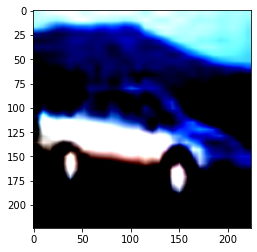

In [30]:
import matplotlib.pyplot as plt
print(t[:20])
plt.imshow(trainset[10000][0].numpy().transpose(1,2,0))

In [31]:
idx=0
epochs=200
random.shuffle(trainlist)
for t,v in cv.split(trainlist):
    idx+=1
    print('Fold :',idx)
    trainset = Mydataset(trainlist,transform)
    valset = Mydataset(trainlist,valt)
    
    trainloader = DataLoader(trainset,batch_size=BATCHSIZE,num_workers=4,sampler=t)
    valloader = DataLoader(valset,batch_size=BATCHSIZE,num_workers=4,sampler=v)
    
    model_name = 'efficientnet_b1'
    
    model=timm.create_model(model_name,num_classes=10)   # Efficient-noisystudent
    model.to(device)
    criterion=nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(),lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(opt,T_max=epochs,eta_min=lr/1e-2)
    
    MODEL=f'{model_name}_224_124_{idx}'
    SAVE_PATH = f'weights/{MODEL}/'
    os.makedirs(SAVE_PATH,exist_ok=True)
    
    train_param={
        'trainloader':trainloader,
        'valloader':valloader,
        'model':model,
        'opt':opt,
        'criterion':criterion,
        'scheduler':scheduler,
        'SAVE_PATH':SAVE_PATH
    }
    
    train(train_param)
    

Fold : 1


100%|██████████| 625/625 [03:14<00:00,  3.22it/s]


[1/200], train_acc=0.39 train_loss=1.79


100%|██████████| 157/157 [00:13<00:00, 11.49it/s]


val acc=0.5222, val_los=1.3435832057029578
	 Current valid Acc | BEST Acc: [0.5222| 0]
	 Best Acc changed [0 ---> 0.5222]


 38%|███▊      | 235/625 [01:12<02:02,  3.19it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7efb94d5fef0>
Traceback (most recent call last):
  File "/home/rjsdn/.conda/envs/vision/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rjsdn/.conda/envs/vision/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1301, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/rjsdn/.conda/envs/vision/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/rjsdn/.conda/envs/vision/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/home/rjsdn/.conda/envs/vision/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/home/rjsdn/.conda/envs/vision/lib/python3.7/selectors.py", li

KeyboardInterrupt: 